In [1]:
import os
#import spacepy.toolbox
#spacepy.toolbox.update(leapsecs=True)
import cdflib
import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

import pysemp

%load_ext autoreload
%autoreload 2

In [2]:
fname = '../../SEMPdemo/20190409/psp_fld_l2_rfs_hfr_20190409_v01.cdf'
dirdata = '../../SEMPdemo/20190409/'

In [3]:
year = "2019"    ## must be in YYYY format 
month = "04"     ## Must be in MM format
day = "09"       ## Must be in DD format    
t0 = datetime.datetime(int(year),int(month),int(day))

# hfr
my_fileh12 = pysemp.psp_dataprep.fnames("hfr",year,month,day,
"V1V2",dirdata=dirdata)
my_fileh34 = pysemp.psp_dataprep.fnames("hfr",year,month,day,
"V3V4",dirdata=dirdata)
    # extract from cdf file
datah12, epochh12, freqsh12 = pysemp.psp_dataprep.data_from_CDF(t0, my_fileh12)
datah34, epochh34, freqsh34 = pysemp.psp_dataprep.data_from_CDF(t0, my_fileh34)

# lfr
my_filel12 = pysemp.psp_dataprep.fnames("lfr",year,month,day,
"V1V2",dirdata=dirdata)
my_filel34 = pysemp.psp_dataprep.fnames("lfr",year,month,day,
"V3V4",dirdata=dirdata)
    # extract from cdf file
datal12, epochl12, freqsl12 = pysemp.psp_dataprep.data_from_CDF(t0, my_filel12)
datal34, epochl34, freqsl34 = pysemp.psp_dataprep.data_from_CDF(t0, my_filel34)

../../SEMPdemo/20190409/psp/psp_fld_l2_rfs_hfr_20190409_v01.cdf


AttributeError: 'CDF' object has no attribute 'get'

In [7]:
dt_anchor = datetime.datetime(2019,4,9,12,0,0)
anchor_time = mdates.date2num(dt_anchor)

sec_epochl12 = (mdates.date2num(epochl12)-anchor_time)*3600*24
sec_epochl34 = (mdates.date2num(epochl12)-anchor_time)*3600*24
sec_epochh12 = (mdates.date2num(epochl12)-anchor_time)*3600*24
sec_epochh34 = (mdates.date2num(epochl12)-anchor_time)*3600*24

#merge
sec_all = (sec_epochl12 + sec_epochh12)/2
idx_range = np.arange(6450,6700)
data_all = np.concatenate(((datal12+datal34)[:,0:56],datah12+datah34),axis=1)
freq_all = np.concatenate((freqsl12[0:56],freqsh12))


In [8]:
# resample
from scipy.interpolate import interp2d

f = interp2d(sec_all,freq_all,data_all.T)

rebin_freq_all=np.logspace(5.5,7.2,150)
rebin_t_all=sec_all
dyspec=f(rebin_t_all,rebin_freq_all)

In [9]:
rebin_data_all = (dyspec-np.tile(np.mean(dyspec,1).T,(dyspec.shape[1],1)).T).T

Text(0.5, 0, 'Seconds from : 2019-04-09 12:00:00')

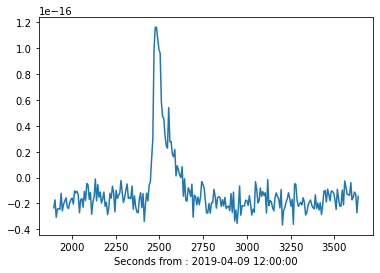

In [19]:
arr_x = (rebin_data_all[idx_range,43])
N_arr_x=arr_x.ravel().shape[0]
idx_x = np.arange(N_arr_x)
x0 = rebin_t_all[idx_range]

ratio_x = 0.7
plt.plot(x0,arr_x)
plt.xlabel('Seconds from : '+str(dt_anchor))


In [20]:

x_dist=np.partition(arr_x,int(ratio_x*N_arr_x))[:int(ratio_x*N_arr_x)]
avg_d = np.mean(x_dist)
arr_x =arr_x - avg_d

var_d = np.std(x_dist)

cursor_prev = idx_x[
    np.where(arr_x[0:np.argmax(arr_x)]<var_d*3)][-1]
idx_fit=idx_x[(cursor_prev-1):(cursor_prev+3)]
fit_parm = np.polyfit(x0[idx_fit],arr_x[idx_fit],1)
x_get_this = -fit_parm[1]/fit_parm[0] 


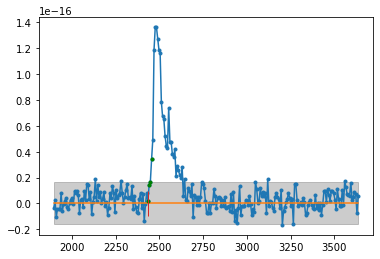

In [22]:
plt.plot(x0, arr_x,'.-')
ax=plt.gca()
ax.plot([x0[0],x0[-1]],[0,0])
ax.fill_between([x0[0],x0[-1]],
   -3*var_d,+3*var_d,color='k',alpha=0.2)
ax.plot(x0[idx_fit], arr_x[idx_fit],'g.')
ax.plot(x_get_this,0,'C3|',zorder=100,markersize=25)

fig = plt.gcf()
fig.savefig('risePoint.pdf')

In [30]:
selected_idx = np.arange(42,145,4)
leading_edge = np.zeros(selected_idx.shape)
for i_n,idx in enumerate(selected_idx) :
    freq_this =  rebin_freq_all[idx]
    arr_this = (rebin_data_all[idx_range,idx])
    leading_edge[i_n] = SEMP.findLeadingPoint(x0,arr_this,ratio_x=0.8,thresh_std = 5)

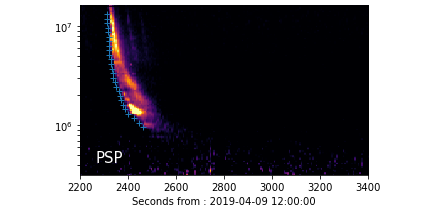

In [31]:

from matplotlib.image import NonUniformImage
fig = plt.figure(figsize=(5,3)) 
ax = fig.add_axes([0.15,0.2,0.8,0.78])

#plt.pcolormesh(x0,freqsh34,np.log10(datah34[idx_range,:].T),shading='auto')
im = NonUniformImage(ax, interpolation='nearest',extent=[x0[0],x0[-1],rebin_freq_all[0],rebin_freq_all[-1]],cmap='inferno')
lin_freq = np.linspace(rebin_freq_all[0],rebin_freq_all[-1],rebin_freq_all.shape[0])
im.set_data(x0,lin_freq,(rebin_data_all[idx_range,:].T))
ax.images.append(im)
ax.set_yscale('log')
im.set_clim([0,3e-16])
ax.set_xlim([2200,3400])
ax.set_ylim([rebin_freq_all[0],rebin_freq_all[-1]])
ax.set_aspect('auto', 'datalim')
ax.set_xlabel('Seconds from : '+str(dt_anchor))
ax.plot(leading_edge,rebin_freq_all[selected_idx],'C0+')
ax.yaxis.set_major_locator(plt.LogLocator(base=10,subs='all'))
ax.text(0.1, 0.1,'PSP',color='w',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
     fontsize=15)

fig.savefig('img/PSP.pdf')

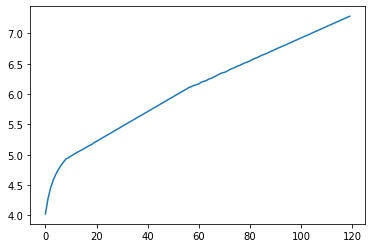

In [32]:

plt.plot(np.log10(np.concatenate((freqsl12[0:56],freqsh34))))

In [33]:
leading_edge

array([2462.801988  , 2444.3749692 , 2423.33167849, 2398.73743509,
       2385.26018785, 2377.63102992, 2371.3639474 , 2364.09737405,
       2361.04408506, 2349.67456338, 2345.37883469, 2338.44160286,
       2335.59162109, 2330.60613456, 2328.19932583, 2327.4321359 ,
       2321.15236093, 2320.48585379, 2319.17269636, 2318.41323808,
       2318.50936951, 2315.03710972, 2314.92786763, 2312.80999923,
       2313.45009289, 2313.00192049])

In [34]:
rebin_freq_all[selected_idx]

array([  953223.25926959,  1058844.57236649,  1176169.18967027,
        1306493.888558  ,  1451259.13502114,  1612065.00499357,
        1790688.86983237,  1989105.04142749,  2209506.59407552,
        2454329.60431273,  2726280.07662782,  3028363.85266155,
        3363919.83447675,  3736656.88911217,  4150694.84232264,
        4610610.01460511,  5121485.802816  ,  5688968.86645318,
        6319331.53962438,  7019541.15853486,  7797337.07076456,
        8661316.17751058,  9621027.95428471, 10687080.00032075,
       11871255.28331836, 13186642.37541819])

In [36]:
np.savez('tmpData/psp_LE.npz',freq_PSP = rebin_freq_all[selected_idx],t_PSP = leading_edge,ds_t_PSP = x0,ds_f_PSP = rebin_freq_all,data_PSP=rebin_data_all[idx_range,:],anchor_dt = dt_anchor)

# save more data
